# IT Incident SLA Comliance Analysis

Service Level Agreement (SLA) compliance represents a critical performance metric in IT service management, directly impacting customer satisfaction, operational efficiency, and business continuity. This analysis examines cleaned IT incident data to identify systematic patterns affecting SLA compliance rates and builds predictive models to forecast potential SLA breaches.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
import shap
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',
              None)  # Display all columns in DataFrame output.
pd.set_option('display.max_rows',
              None)  # Display all rows in DataFrame output.
# Load data from dataset
df = pd.read_csv('../data/incidents_cleaned.csv')

# Display DataFrame information
df.info()
print(f"\nDataset shape: {df.shape}")
print(f"\nTarget Variable Distribution:")
print(df['made_sla'].value_counts())
print(f"SLA Compliance Rate: {df['made_sla'].mean():.1%}")
print(f"SLA Breach Rate: {(1 - df['made_sla'].mean()):.1%}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6729 entries, 0 to 6728
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   number                   6729 non-null   object
 1   incident_state           6729 non-null   object
 2   active                   6729 non-null   bool  
 3   reassignment_count       6729 non-null   int64 
 4   reopen_count             6729 non-null   int64 
 5   sys_mod_count            6729 non-null   int64 
 6   made_sla                 6729 non-null   bool  
 7   caller_id                6727 non-null   object
 8   opened_by                6432 non-null   object
 9   opened_at                6729 non-null   object
 10  sys_created_by           3784 non-null   object
 11  sys_created_at           3784 non-null   object
 12  sys_updated_by           6729 non-null   object
 13  sys_updated_at           6729 non-null   object
 14  contact_type             6729 non-null  

## 1. Feature Engineering

### 1.1 Operational Complexity Features

In [90]:
df_fe = df.copy()

EDA revealed that operational metrics (sys_mod_count, reassignment_count) are the strongest predictors of SLA compliance. However, raw counts don't capture the complexity of incident handling. We create composite metrics to measure:Overall handling complexity (weighted activity score), Binary flags for threshold-based risk indicators.

- sys_mod_count threshold at 3: EDA showed >99% SLA compliance for 0-3 modifications vs <95% for 4+ modifications
- reassignment_count threshold at 0: 93.1% SLA vs 84.8% (8.3% gap)
- Combined complexity flag captures incidents requiring extensive handling

In [91]:
# Weighted activity score
# Weights reflect impact magnitude from EDA:
#   - System modifications: 1x (baseline complexity)
#   - Reassignments: 2x (routing failures, knowledge gaps, higher impact)
# Note: Excludes reopen_count (post-incident data, not available at prediction time)
df_fe['activity_score'] = (df_fe['sys_mod_count'] +
                           df_fe['reassignment_count'] * 2)

# Binary complexity flags based on EDA-identified thresholds
df_fe['has_reassignment'] = (df_fe['reassignment_count'] > 0).astype(int)
df_fe['high_modification'] = (df_fe['sys_mod_count'] > 3).astype(int)

# Simplified complexity flag (MODIFIED: exclude reopen_count condition)
df_fe['is_complex'] = ((df_fe['sys_mod_count'] > 4) |
                       (df_fe['reassignment_count'] > 2)).astype(int)

# Validation: Verify feature effectiveness
complex_sla = df_fe.groupby('is_complex')['made_sla'].mean()
print(f"\nValidation - is_complex feature:")
print(f"  Simple: {complex_sla[0]:.1%}, Complex: {complex_sla[1]:.1%}")
print(f"  Gap: {(complex_sla[0]-complex_sla[1])*100:.1f}%")


Validation - is_complex feature:
  Simple: 98.7%, Complex: 69.4%
  Gap: 29.2%


### 1.2 Severity Features

Priority, Impact, and Urgency exhibit strong multicollinearity (r=0.75-0.89), meaning they capture overlapping information. Using all three would introduce redundancy and potential multicollinearity issues in linear models.

- Convert categorical severity levels to binary "high vs low" flags
- Create composite "high_severity" flag: ANY dimension marked as high
- EDA Performance gaps:
    Priority: Critical 53.3% vs Low 95.5% (42.2% gap)
    Impact: High 51.6% vs Low 95.8% (44.2% gap)
    Urgency: High 56.8% vs Low 94.8% (38.0% gap)


In [92]:
# Binary severity flags (convert categorical to 0/1)
df_fe['is_high_priority'] = df_fe['priority'].isin(
    ['1 - Critical', '2 - High']).astype(int)
df_fe['is_high_impact'] = df_fe['impact'].isin(['1 - High']).astype(int)
df_fe['is_high_urgency'] = df_fe['urgency'].isin(['1 - High']).astype(int)
df_fe['is_high_severity'] = ((df_fe['is_high_priority'] == 1) |
                             (df_fe['is_high_impact'] == 1) |
                             (df_fe['is_high_urgency'] == 1)).astype(int)

sev_sla = df_fe.groupby('is_high_severity')['made_sla'].mean()
print(f"\nValidation - is_high_severity feature performance:")
print(f"  Low severity (0): {sev_sla[0]:.1%} SLA compliance")
print(f"  High severity (1): {sev_sla[1]:.1%} SLA compliance")
print(
    f"  Performance gap: {(sev_sla[0]-sev_sla[1])*100:.1f} percentage points")


Validation - is_high_severity feature performance:
  Low severity (0): 87.4% SLA compliance
  High severity (1): 54.9% SLA compliance
  Performance gap: 32.5 percentage points


### 1.3 Interaction Features

Individual features may not capture compounding effects. For example, a high-severity incident that also requires complex handling likely has multiplicative negative impact on SLA compliance rather than simple additive effect.

- Severity × Complexity: Worst-case scenario (urgent + extensive handling)
- Priority Confirmation × Complexity: Confirmed complex cases (procedural flag)
- High Priority × Reassignment: Urgent cases with routing failures

In [93]:
# Severity + Complexity
df_fe['severity_complexity'] = (df_fe['is_high_severity'] * df_fe['is_complex']).astype(int)

# Priority confirmation + Complexity  
# Note: u_priority_confirmation is available at incident time (procedural flag)
df_fe['confirmed_complex'] = (df_fe['u_priority_confirmation'] * df_fe['is_complex']).astype(int)

# High priority + Reassignment
df_fe['priority_reassign'] = (df_fe['is_high_priority'] * df_fe['has_reassignment']).astype(int)

risk_sla = df_fe.groupby('severity_complexity')['made_sla'].mean()
print(f"Validation: No risk {risk_sla[0]:.1%}, High risk {risk_sla[1]:.1%}, Gap {(risk_sla[0]-risk_sla[1])*100:.1f}%")

print("\n" + "-"*80)
print(f"Feature Engineering Summary:")
print(f"  Original: {df.shape[1]} → Engineered: {df_fe.shape[1]} (+{df_fe.shape[1]-df.shape[1]} features)")
print(f"  Excluded post-incident metrics: closed_time, reopen_count, per_day ratios")
print("-"*80)

Validation: No risk 87.3%, High risk 50.3%, Gap 36.9%

--------------------------------------------------------------------------------
Feature Engineering Summary:
  Original: 32 → Engineered: 43 (+11 features)
  Excluded post-incident metrics: closed_time, reopen_count, per_day ratios
--------------------------------------------------------------------------------


### 1.4 Feature Encoding

#### 1.4.1 Ordinal Encoding

Priority, Impact, and Urgency have natural ordering from low to high severity. Preserve this ordering with numeric encoding

In [94]:
df_enc = df_fe.copy()

In [95]:
# Priority (1=Low, 4=Critical)
priority_map = {
    '4 - Low': 1,
    '3 - Moderate': 2,
    '2 - High': 3,
    '1 - Critical': 4
}
df_enc['priority_enc'] = df_enc['priority'].map(priority_map)

# Impact (1=Low, 3=High)
impact_map = {'3 - Low': 1, '2 - Medium': 2, '1 - High': 3}
df_enc['impact_enc'] = df_enc['impact'].map(impact_map)

# Urgency (1=Low, 3=High)
urgency_map = {'3 - Low': 1, '2 - Medium': 2, '1 - High': 3}
df_enc['urgency_enc'] = df_enc['urgency'].map(urgency_map)

print("✓ Ordinal encoded 3 variables:")
print("  - priority_enc: 1 (Low) → 4 (Critical)")
print("  - impact_enc: 1 (Low) → 3 (High)")
print("  - urgency_enc: 1 (Low) → 3 (High)")


✓ Ordinal encoded 3 variables:
  - priority_enc: 1 (Low) → 4 (Critical)
  - impact_enc: 1 (Low) → 3 (High)
  - urgency_enc: 1 (Low) → 3 (High)


#### 1.4.2 Label Encoding

assignment_group and category have many unique values without natural ordering

In [96]:
# assignment_group (from EDA: 56% performance variance across groups)
le_group = LabelEncoder()
df_enc['assignment_group'] = df_enc['assignment_group'].fillna('Unknown')
df_enc['assignment_group_enc'] = le_group.fit_transform(
    df_enc['assignment_group'])

# category (from EDA: 21.1% performance gap)
le_cat = LabelEncoder()
df_enc['category'] = df_enc['category'].fillna('Unknown')
df_enc['category_enc'] = le_cat.fit_transform(df_enc['category'])

print(f"✓ Label encoded 2 variables:")
print(f"  - assignment_group_enc: {len(le_group.classes_)} unique groups")
print(f"  - category_enc: {len(le_cat.classes_)} unique categories")

✓ Label encoded 2 variables:
  - assignment_group_enc: 65 unique groups
  - category_enc: 47 unique categories


#### 1.4.3 Binary Encoding

Binary features created during feature engineering need to be explicitly typed as integers

In [97]:
binary_vars = [
    'knowledge', 'u_priority_confirmation', 'made_sla', 'has_reassignment',
    'high_modification', 'is_complex', 'is_high_priority', 'is_high_impact',
    'is_high_urgency', 'is_high_severity', 'severity_complexity',
    'confirmed_complex', 'priority_reassign'
]

for var in binary_vars:
    if var in df_enc.columns:
        df_enc[var] = df_enc[var].astype(int)

verified_count = len([v for v in binary_vars if v in df_enc.columns])
print(f"✓ Verified {verified_count} binary variables as integer type")

✓ Verified 13 binary variables as integer type


### 2. Feature Selection

Feature selection aims to identify the most predictive features while reducing dimensionality and preventing overfitting. We employ two complementary methods:
1. Filter Method (ANOVA F-test):
   - Statistical test measuring relationship between each feature and target
   - Fast, model-agnostic approach
   - Identifies univariate relationships
2. Embedded Method (Random Forest Feature Importance):
   - Features selected during model training
   - Captures feature interactions and non-linear relationships
   - Specific to tree-based models
We combine both methods using the union of selected features to ensure
we capture both statistical significance and model-specific importance.

### 2.1 Define Candidate Features

Prepare feature groups based on their types and encoding methods

In [98]:
# Define target variable
target = 'made_sla'

# Numerical features (continuous and ordinal encoded)
numerical_features = [
    'priority_enc',
    'impact_enc',
    'urgency_enc',  # Ordinal encoded severity
    'reassignment_count',
    'sys_mod_count',  # Raw operational counts
    'activity_score'  # Weighted complexity
]

# Categorical features (label encoded)
categorical_features = [
    'assignment_group_enc',  # Support team assignment
    'category_enc'  # Incident category
]

# Binary features (0/1 flags)
binary_features = [
    'knowledge',
    'u_priority_confirmation',  # Process flags
    'has_reassignment',
    'high_modification',
    'is_complex',  # Complexity flags
    'is_high_priority',
    'is_high_impact',
    'is_high_urgency',
    'is_high_severity',  # Severity flags
    'severity_complexity',
    'confirmed_complex',
    'priority_reassign'  # Interaction flags
]

# Combine all candidate features
all_features = numerical_features + categorical_features + binary_features
available_features = [f for f in all_features if f in df_enc.columns]

print(f"Candidate Features Summary:")
print(f"  Total: {len(available_features)} features")
print(
    f"    - Numerical (including ordinal): {len([f for f in numerical_features if f in df_enc.columns])}"
)
print(
    f"    - Categorical (label encoded): {len([f for f in categorical_features if f in df_enc.columns])}"
)
print(
    f"    - Binary (flags): {len([f for f in binary_features if f in df_enc.columns])}"
)

X = df_enc[available_features].copy()
y = df_enc[target].copy()
X = X.fillna(X.median())

print(f"\nX shape: {X.shape}, y shape: {y.shape}")

Candidate Features Summary:
  Total: 20 features
    - Numerical (including ordinal): 6
    - Categorical (label encoded): 2
    - Binary (flags): 12

X shape: (6729, 20), y shape: (6729,)


### 2.2 Prepare Feature Matrix

Extract features and target, handle missing values

In [99]:
# Prepare X (features) and y (target)
X = df_enc[available_features].copy()
y = df_enc[target].copy()

# Handle missing values using median imputation
# Median is robust to outliers and appropriate for numerical/ordinal features
X = X.fillna(X.median())

print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Class 1 (SLA Met): {y.sum():,} ({y.mean():.1%})")
print(
    f"  Class 0 (SLA Breach): {(~y.astype(bool)).sum():,} ({(1-y.mean()):.1%})"
)
print(f"  Class imbalance ratio: {y.sum() / (~y.astype(bool)).sum():.2f}:1")


Feature matrix (X) shape: (6729, 20)
Target vector (y) shape: (6729,)

Target distribution:
  Class 1 (SLA Met): 5,813 (86.4%)
  Class 0 (SLA Breach): 916 (13.6%)
  Class imbalance ratio: 6.35:1


### 2.3 Filter Method: ANOVA F-test

This code selects the k best features from X that have the strongest statistical relationship with y according to the ANOVA F-test

In [110]:
k_best = 20  # Select top 20 features
selector_anova = SelectKBest(score_func=f_classif, k=k_best)
X_anova = selector_anova.fit_transform(X, y)

anova_mask = selector_anova.get_support()
anova_features = X.columns[anova_mask].tolist()
anova_scores = selector_anova.scores_[anova_mask]

print(f"\nANOVA Top {k_best}:")
for rank, (feat, score) in enumerate(
        sorted(zip(anova_features, anova_scores),
               key=lambda x: x[1],
               reverse=True)[:10], 1):
    print(f"  {rank}. {feat:30s} F={score:.2f}")


ANOVA Top 20:
  1. confirmed_complex              F=1694.81
  2. is_complex                     F=1446.74
  3. activity_score                 F=1157.19
  4. high_modification              F=1095.61
  5. sys_mod_count                  F=1084.96
  6. reassignment_count             F=463.56
  7. has_reassignment               F=320.08
  8. is_high_priority               F=192.76
  9. is_high_severity               F=192.76
  10. u_priority_confirmation        F=190.19


### 2.4 Embedded Method: Random Forest Feature Importance


Random Forest Top 20:
  1. sys_mod_count                  Imp=0.2025
  2. activity_score                 Imp=0.1892
  3. confirmed_complex              Imp=0.1610
  4. is_complex                     Imp=0.1087
  5. high_modification              Imp=0.1003
  6. assignment_group_enc           Imp=0.0511
  7. category_enc                   Imp=0.0471
  8. reassignment_count             Imp=0.0258
  9. u_priority_confirmation        Imp=0.0238
  10. has_reassignment               Imp=0.0164

Final: 20 features selected


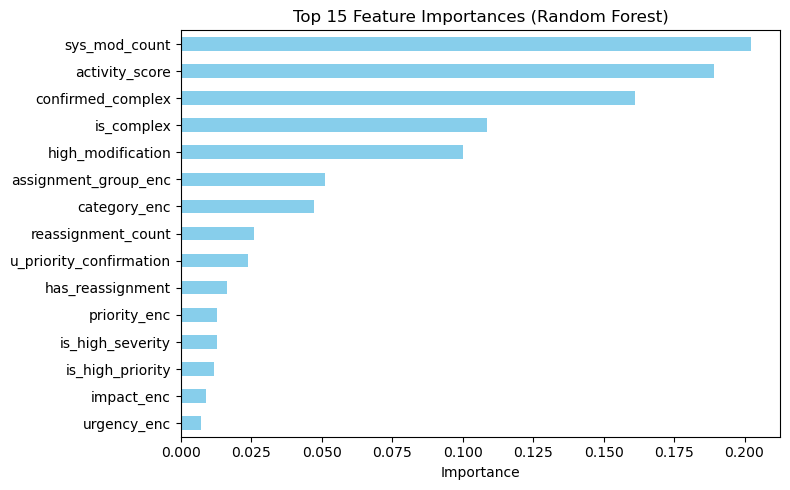

In [101]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            random_state=42,
                            n_jobs=-1,
                            class_weight='balanced')
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
rf_features = importances.head(k_best).index.tolist()

print(f"\nRandom Forest Top {k_best}:")
for rank, (feat, imp) in enumerate(importances.head(10).items(), 1):
    print(f"  {rank}. {feat:30s} Imp={imp:.4f}")

selected_features = list(set(anova_features + rf_features))
selected_features.sort()

print(f"\nFinal: {len(selected_features)} features selected")

X_selected = X[selected_features].copy()

plt.figure(figsize=(8, 5))
importances.head(15).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 2.5 Combine Methods

In [102]:
selected_features = list(set(anova_features + rf_features))
selected_features.sort()

print(f"Results:")
print(f"  ANOVA: {len(anova_features)} features")
print(f"  Random Forest: {len(rf_features)} features")
print(f"  Union: {len(selected_features)} features")
print(f"  Overlap: {len(set(anova_features) & set(rf_features))} features")

print(f"\nFinal Selected Features ({len(selected_features)}):\n")
print(f"{'#':<4} {'Feature':<35} {'ANOVA':<8} {'RF':<8}")
print("-" * 57)
for i, feat in enumerate(selected_features, 1):
    in_anova = "✓" if feat in anova_features else " "
    in_rf = "✓" if feat in rf_features else " "
    print(f"{i:<4} {feat:<35} {in_anova:<8} {in_rf:<8}")

X_selected = X[selected_features].copy()

print(f"\nDimensionality Reduction:")
print(
    f"  Original: {X.shape[1]} → Selected: {X_selected.shape[1]} ({(1-X_selected.shape[1]/X.shape[1])*100:.1f}% reduction)"
)

Results:
  ANOVA: 20 features
  Random Forest: 20 features
  Union: 20 features
  Overlap: 20 features

Final Selected Features (20):

#    Feature                             ANOVA    RF      
---------------------------------------------------------
1    activity_score                      ✓        ✓       
2    assignment_group_enc                ✓        ✓       
3    category_enc                        ✓        ✓       
4    confirmed_complex                   ✓        ✓       
5    has_reassignment                    ✓        ✓       
6    high_modification                   ✓        ✓       
7    impact_enc                          ✓        ✓       
8    is_complex                          ✓        ✓       
9    is_high_impact                      ✓        ✓       
10   is_high_priority                    ✓        ✓       
11   is_high_severity                    ✓        ✓       
12   is_high_urgency                     ✓        ✓       
13   knowledge                          

#### 2.6 Feature Scaling

In [103]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled_df = pd.DataFrame(X_scaled,
                           columns=X_selected.columns,
                           index=X_selected.index)

print(f"\n✓ Scaled {X_scaled_df.shape[1]} features")

## 4. SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_scaled_df, y)

print(f"\n✓ SMOTE: {len(y):,} → {len(y_resampled):,} samples")

## 5. Save
balanced_data = pd.DataFrame(X_resampled, columns=X_scaled_df.columns)
balanced_data['made_sla'] = y_resampled
balanced_data.to_csv('../data/incidents_smote_balanced.csv', index=False)

print(f"\n✓ Saved to 'incidents_smote_balanced.csv'")
print(f"  Shape: {balanced_data.shape}")
print(f"  Features: Pre-incident only (no post-incident leakage)")


✓ Scaled 20 features

✓ SMOTE: 6,729 → 11,626 samples

✓ Saved to 'incidents_smote_balanced.csv'
  Shape: (11626, 21)
  Features: Pre-incident only (no post-incident leakage)


### 3. Model Training and Evaluation - Supervised Learning

#### 3.1 Train-Test Split

Split SMOTE-balanced data for training, use original distribution for testing

In [104]:
# Load SMOTE-balanced data
balanced_data = pd.read_csv('../data/incidents_smote_balanced.csv')
X_balanced = balanced_data.drop('made_sla', axis=1)
y_balanced = balanced_data['made_sla']

print(f"Balanced dataset: {X_balanced.shape[0]:,} samples")
print(f"  Class 0 (Breach): {(y_balanced==0).sum():,}")
print(f"  Class 1 (Met): {(y_balanced==1).sum():,}")

# Split: 80% train, 20% test
# stratify ensures both sets maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X_balanced,
                                                    y_balanced,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_balanced)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"  Class 0: {(y_train==0).sum():,} ({(y_train==0).mean():.1%})")
print(f"  Class 1: {(y_train==1).sum():,} ({(y_train==1).mean():.1%})")

print(f"\nTest set: {X_test.shape[0]:,} samples")
print(f"  Class 0: {(y_test==0).sum():,} ({(y_test==0).mean():.1%})")
print(f"  Class 1: {(y_test==1).sum():,} ({(y_test==1).mean():.1%})")

Balanced dataset: 11,626 samples
  Class 0 (Breach): 5,813
  Class 1 (Met): 5,813

Train set: 9,300 samples
  Class 0: 4,650 (50.0%)
  Class 1: 4,650 (50.0%)

Test set: 2,326 samples
  Class 0: 1,163 (50.0%)
  Class 1: 1,163 (50.0%)


#### 3.2 Model Training

Train three algorithms with appropriate hyperparameters

In [105]:
# Dictionary to store trained models
models = {}

#### (1) Logistic Regression
print("\n(1) Logistic Regression (Baseline)")
print("    Hyperparameters:")
print("      - max_iter=1000 (ensure convergence)")
print("      - random_state=42 (reproducibility)")
print("      - class_weight='balanced' (handle any residual imbalance)\n")

lr = LogisticRegression(max_iter=1000,
                        random_state=42,
                        class_weight='balanced')
lr.fit(X_train, y_train)
models['Logistic Regression'] = lr
print("    ✓ Training complete")

#### (2) Random Forest
print("\n(2) Random Forest Classifier")
print("    Hyperparameters:")
print("      - n_estimators=100 (number of trees)")
print("      - max_depth=15 (control overfitting)")
print("      - min_samples_split=10 (minimum samples to split node)")
print("      - class_weight='balanced' (emphasize minority class)")
print("      - random_state=42, n_jobs=-1 (reproducibility, parallel)\n")

rf = RandomForestClassifier(n_estimators=100,
                            max_depth=15,
                            min_samples_split=10,
                            class_weight='balanced',
                            random_state=42,
                            n_jobs=-1)
rf.fit(X_train, y_train)
models['Random Forest'] = rf
print("    ✓ Training complete")

#### (3) Gradient Boosting
print("\n(3) Gradient Boosting Classifier")
print("    Hyperparameters:")
print("      - n_estimators=100 (number of boosting stages)")
print("      - learning_rate=0.1 (shrinkage parameter)")
print("      - max_depth=5 (depth of individual trees)")
print("      - random_state=42 (reproducibility)\n")

gb = GradientBoostingClassifier(n_estimators=100,
                                learning_rate=0.1,
                                max_depth=5,
                                random_state=42)
gb.fit(X_train, y_train)
models['Gradient Boosting'] = gb
print("    ✓ Training complete")

print("\n" + "-" * 80)
print(f"All {len(models)} models trained successfully")
print("-" * 80)


(1) Logistic Regression (Baseline)
    Hyperparameters:
      - max_iter=1000 (ensure convergence)
      - random_state=42 (reproducibility)
      - class_weight='balanced' (handle any residual imbalance)

    ✓ Training complete

(2) Random Forest Classifier
    Hyperparameters:
      - n_estimators=100 (number of trees)
      - max_depth=15 (control overfitting)
      - min_samples_split=10 (minimum samples to split node)
      - class_weight='balanced' (emphasize minority class)
      - random_state=42, n_jobs=-1 (reproducibility, parallel)

    ✓ Training complete

(3) Gradient Boosting Classifier
    Hyperparameters:
      - n_estimators=100 (number of boosting stages)
      - learning_rate=0.1 (shrinkage parameter)
      - max_depth=5 (depth of individual trees)
      - random_state=42 (reproducibility)

    ✓ Training complete

--------------------------------------------------------------------------------
All 3 models trained successfully
-------------------------------------

#### 3.3 Model Evaluation

In [106]:
# Store results for comparison
results = []

for model_name, model in models.items():
    print(f"\n{model_name}")
    print("-" * 80)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,
                                pos_label=0)  # Breach = positive class
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    # Print metrics
    print(f"Accuracy:  {accuracy:.4f}")
    print(
        f"Precision (Breach): {precision:.4f}  ← Out of predicted breaches, {precision:.1%} were correct"
    )
    print(
        f"Recall (Breach):    {recall:.4f}  ← Detected {recall:.1%} of actual breaches"
    )
    print(
        f"F1-Score (Breach):  {f1:.4f}  ← Harmonic mean of precision & recall")
    print(f"ROC-AUC:   {roc_auc:.4f}  ← Overall discriminative ability")

    # Confusion Matrix
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tp, fn, fp, tn = cm.ravel()

    cm_df = pd.DataFrame([[tp, fn], [fp, tn]],
                         index=["Actual Breach", "Actual Met"],
                         columns=["Predicted Breach", "Predicted Met"])
    print(cm_df)

    print(
        f"\n  True Positives (TP):  {tp:4d}  ← Breaches correctly identified")
    print(
        f"  False Negatives (FN): {fn:4d}  ← Breaches missed (Type II error)")
    print(f"  False Positives (FP): {fp:4d}  ← False alarms (Type I error)")
    print(f"  True Negatives (TN):  {tn:4d}  ← SLA Met correctly identified")

# Summary comparison table
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

results_df = pd.DataFrame(results)
print(f"\n{results_df.to_string(index=False)}")

# Identify best model
best_model = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"\n→ Best Model (by F1-Score): {best_model['Model']}")
print(f"  F1-Score: {best_model['F1-Score']:.4f}")
print(
    f"  Recall: {best_model['Recall']:.4f} (detects {best_model['Recall']:.1%} of SLA breaches)"
)


Logistic Regression
--------------------------------------------------------------------------------
Accuracy:  0.8224
Precision (Breach): 0.7548  ← Out of predicted breaches, 75.5% were correct
Recall (Breach):    0.9553  ← Detected 95.5% of actual breaches
F1-Score (Breach):  0.8433  ← Harmonic mean of precision & recall
ROC-AUC:   0.8904  ← Overall discriminative ability

Confusion Matrix:
               Predicted Breach  Predicted Met
Actual Breach              1111             52
Actual Met                  361            802

  True Positives (TP):  1111  ← Breaches correctly identified
  False Negatives (FN):   52  ← Breaches missed (Type II error)
  False Positives (FP):  361  ← False alarms (Type I error)
  True Negatives (TN):   802  ← SLA Met correctly identified

Random Forest
--------------------------------------------------------------------------------
Accuracy:  0.8981
Precision (Breach): 0.8551  ← Out of predicted breaches, 85.5% were correct
Recall (Breach):    0.95